In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import os

/Users/utoglu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/utoglu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

False
None


In [3]:
file_path = 'datasets/DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]
print("Filtered dataset size:", len(df))

extra_path = 'datasets/dataset2.xlsx'
if os.path.exists(extra_path):
    df_extra_raw = pd.read_excel(extra_path)
    cols_lower = {c.lower().strip(): c for c in df_extra_raw.columns}

    def pick(col_candidates):
        for name in col_candidates:
            if name.lower() in cols_lower:
                return cols_lower[name.lower()]
        return None

    chrom_col = pick(["chromophore", "smiles"])
    solv_col  = pick(["solvent"])
    qy_col    = pick(["quantum yield", "plqy", "plq y", "qy"])

    if chrom_col and solv_col and qy_col:
        df_extra = df_extra_raw[[chrom_col, solv_col, qy_col]].rename(
            columns={chrom_col: "Chromophore", solv_col: "Solvent", qy_col: "Quantum yield"}
        )
        df_extra = df_extra[df_extra["Quantum yield"].notna()
                            & df_extra["Chromophore"].notna()
                            & df_extra["Solvent"].notna()]
        df_extra = df_extra[df_extra["Quantum yield"] >= 0.01]
        print("Extra dataset usable rows:", len(df_extra))

   
        df = pd.concat([df, df_extra], ignore_index=True)
    else:
        print("dataset2.xlsx found but required columns (SMILES/chromophore, solvent, PLQY/Quantum yield) not detected; using only base CSV.")
else:
    print("Extra dataset 'dataset2.xlsx' not found; using only base CSV.")

print("Total combined filtered dataset size:", len(df))
df.head()

Filtered dataset size: 12541
Extra dataset usable rows: 2912
Total combined filtered dataset size: 15453


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


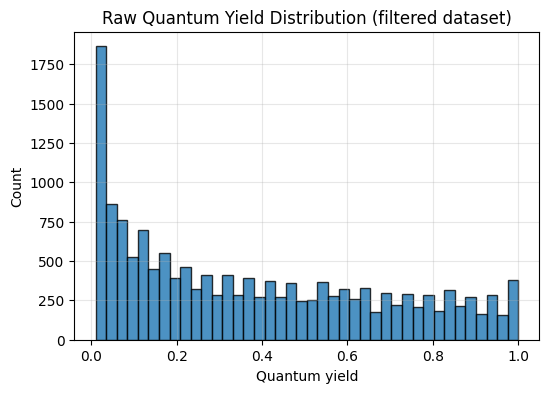

In [4]:

plt.figure(figsize=(6,4))
plt.hist(df["Quantum yield"], bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield")
plt.ylabel("Count")
plt.title("Raw Quantum Yield Distribution (filtered dataset)")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [6]:

import torch

CACHE_FILE = "embedding caches/embedding_cache.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {} 

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [7]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [8]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([15453, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([15453, 768])
Combined embedding shape: torch.Size([15453, 1536])


In [9]:
from sklearn.preprocessing import StandardScaler

chrom_emb_scaled = torch.tensor(StandardScaler().fit_transform(chrom_emb.numpy()), dtype=torch.float32)
solv_emb_scaled = torch.tensor(StandardScaler().fit_transform(solv_emb.numpy()), dtype=torch.float32)
combined_emb = torch.cat([chrom_emb_scaled, solv_emb_scaled], dim=1)
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)

In [10]:

RANDOM_STATE = 42

chrom_trainval, chrom_test, solv_trainval, solv_test, y_trainval, y_test = train_test_split(
    chrom_emb_scaled, solv_emb_scaled, y, test_size=0.20, random_state=RANDOM_STATE
)

val_frac_of_trainval = 0.10 / 0.80  
chrom_train, chrom_val, solv_train, solv_val, y_train, y_val = train_test_split(
    chrom_trainval, solv_trainval, y_trainval, test_size=val_frac_of_trainval, random_state=RANDOM_STATE
)

N_total = chrom_emb_scaled.shape[0]
print(f"Total samples: {N_total}")
print(f"Train samples: {len(chrom_train)} ({len(chrom_train)/N_total:.2%})")
print(f"Val   samples: {len(chrom_val)} ({len(chrom_val)/N_total:.2%})")
print(f"Test  samples: {len(chrom_test)} ({len(chrom_test)/N_total:.2%})")

train_ds = TensorDataset(chrom_train, solv_train, y_train)
val_ds   = TensorDataset(chrom_val,   solv_val,   y_val)
test_ds  = TensorDataset(chrom_test,  solv_test,  y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Total samples: 15453
Train samples: 10816 (69.99%)
Val   samples: 1546 (10.00%)
Test  samples: 3091 (20.00%)


In [11]:
for name, loader in (("train", train_loader), ("val", val_loader), ("test", test_loader)):
    xb_ch, xb_sv, yb = next(iter(loader))
    print(f"{name} batch shapes -> chrom: {xb_ch.shape}, solv: {xb_sv.shape}, y: {yb.shape}")

train batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
val batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
test batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])


In [12]:
#Transformer

In [13]:

class TransformerRegressorImproved(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, 
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.4), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)
    
    def predict(self, chrom, solv, device='cpu'):
        """Predict on numpy arrays or tensors (returns numpy)"""
        self.eval()
        with torch.no_grad():
            if not isinstance(chrom, torch.Tensor):
                chrom = torch.tensor(chrom, dtype=torch.float32)
            if not isinstance(solv, torch.Tensor):
                solv = torch.tensor(solv, dtype=torch.float32)
            chrom = chrom.to(device)
            solv = solv.to(device)
            pred = self.forward(chrom, solv)
            return pred.cpu().numpy()


In [14]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)
    
    def predict(self, chrom, solv, device='cpu'):
        """Predict on numpy arrays or tensors (returns numpy)"""
        self.eval()
        with torch.no_grad():
            if not isinstance(chrom, torch.Tensor):
                chrom = torch.tensor(chrom, dtype=torch.float32)
            if not isinstance(solv, torch.Tensor):
                solv = torch.tensor(solv, dtype=torch.float32)
            chrom = chrom.to(device)
            solv = solv.to(device)
            pred = self.forward(chrom, solv)
            return pred.cpu().numpy()


In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]

transformer_improved = TransformerRegressorImproved(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2, dropout=0.3).to(device)

criterion = nn.MSELoss()
optimizer_improved = torch.optim.Adam(transformer_improved.parameters(), lr=1e-4, weight_decay=1e-5)

epochs = 200
train_losses_improved = []
val_losses_improved = []

early_stopping_patience = 30
best_val_loss_improved = float('inf')
patience_counter_improved = 0
best_epoch_improved = 0

best_model_path_improved = "models/transformer_improved_best.pth"

print(f"Starting training IMPROVED model with early stopping (patience={early_stopping_patience} epochs)...")
print("Regularization: dropout=0.3 in encoder, 0.4/0.3 in regressor, weight_decay=1e-5, gradient clipping")
print("=" * 70)

for epoch in range(epochs):
    # Training phase
    transformer_improved.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass
        pred = transformer_improved(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        # Backward pass
        optimizer_improved.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients and improve stability
        torch.nn.utils.clip_grad_norm_(transformer_improved.parameters(), max_norm=1.0)
        optimizer_improved.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses_improved.append(avg_train_loss)
    
    # Validation phase
    transformer_improved.eval()
    val_total_loss = 0
    with torch.no_grad():
        for chrom_batch, solv_batch, yb in val_loader:
            chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
            pred = transformer_improved(chrom_batch, solv_batch)
            loss = criterion(pred, yb)
            val_total_loss += loss.item()
    
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses_improved.append(avg_val_loss)
    
    # Early stopping logic
    if avg_val_loss < best_val_loss_improved:
        best_val_loss_improved = avg_val_loss
        best_epoch_improved = epoch + 1
        patience_counter_improved = 0
        # Save best model
        torch.save(transformer_improved.state_dict(), best_model_path_improved)
    else:
        patience_counter_improved += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
              f"Best Val Loss: {best_val_loss_improved:.6f} (Epoch {best_epoch_improved}) | Patience: {patience_counter_improved}/{early_stopping_patience}")
    
    # Check for early stopping
    if patience_counter_improved >= early_stopping_patience:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
        print(f"Best validation loss: {best_val_loss_improved:.6f} at epoch {best_epoch_improved}")
        print(f"Stopping training at epoch {epoch + 1}")
        print(f"{'='*70}")
        break

print(f"\nTraining complete! Best improved model saved at: {best_model_path_improved}")
print(f"Best validation loss: {best_val_loss_improved:.6f} at epoch {best_epoch_improved}")
print(f"Total epochs trained: {len(train_losses_improved)}")


Using device: cpu
Starting training IMPROVED model with early stopping (patience=30 epochs)...
Regularization: dropout=0.3 in encoder, 0.4/0.3 in regressor, weight_decay=1e-5, gradient clipping
Epoch 1/200 | Train Loss: 0.090323 | Val Loss: 0.069963 | Best Val Loss: 0.069963 (Epoch 1) | Patience: 0/30
Epoch 10/200 | Train Loss: 0.046577 | Val Loss: 0.048303 | Best Val Loss: 0.048303 (Epoch 10) | Patience: 0/30
Epoch 20/200 | Train Loss: 0.031272 | Val Loss: 0.042586 | Best Val Loss: 0.041521 (Epoch 18) | Patience: 2/30
Epoch 30/200 | Train Loss: 0.023590 | Val Loss: 0.037750 | Best Val Loss: 0.037635 (Epoch 28) | Patience: 2/30
Epoch 40/200 | Train Loss: 0.019104 | Val Loss: 0.035512 | Best Val Loss: 0.035512 (Epoch 40) | Patience: 0/30
Epoch 50/200 | Train Loss: 0.015571 | Val Loss: 0.035090 | Best Val Loss: 0.035090 (Epoch 50) | Patience: 0/30
Epoch 60/200 | Train Loss: 0.013690 | Val Loss: 0.035105 | Best Val Loss: 0.035090 (Epoch 50) | Patience: 10/30
Epoch 70/200 | Train Loss: 0.0

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]
transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 200
train_losses = []
val_losses = []

early_stopping_patience = 30
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

os.makedirs("models", exist_ok=True)
best_model_path = "models/transformer_best.pth"

print(f"Starting training with early stopping (patience={early_stopping_patience} epochs)...")
print("=" * 70)

for epoch in range(epochs):

    transformer_model.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        

        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    

    transformer_model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for chrom_batch, solv_batch, yb in val_loader:
            chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
            pred = transformer_model(chrom_batch, solv_batch)
            loss = criterion(pred, yb)
            val_total_loss += loss.item()
    
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0

        torch.save(transformer_model.state_dict(), best_model_path)
    else:
        patience_counter += 1
    

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
              f"Best Val Loss: {best_val_loss:.6f} (Epoch {best_epoch}) | Patience: {patience_counter}/{early_stopping_patience}")
    

    if patience_counter >= early_stopping_patience:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
        print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
        print(f"Stopping training at epoch {epoch + 1}")
        print(f"{'='*70}")
        break


print(f"\nTraining complete! Best model saved at: {best_model_path}")
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
print(f"Total epochs trained: {len(train_losses)}")

Using device: cpu
Starting training with early stopping (patience=30 epochs)...
Epoch 1/200 | Train Loss: 0.081799 | Val Loss: 0.066619 | Best Val Loss: 0.066619 (Epoch 1) | Patience: 0/30
Epoch 10/200 | Train Loss: 0.027589 | Val Loss: 0.041322 | Best Val Loss: 0.040932 (Epoch 9) | Patience: 1/30
Epoch 20/200 | Train Loss: 0.014587 | Val Loss: 0.038403 | Best Val Loss: 0.037843 (Epoch 12) | Patience: 8/30
Epoch 30/200 | Train Loss: 0.010241 | Val Loss: 0.036898 | Best Val Loss: 0.035994 (Epoch 26) | Patience: 4/30
Epoch 40/200 | Train Loss: 0.008078 | Val Loss: 0.038385 | Best Val Loss: 0.035555 (Epoch 39) | Patience: 1/30
Epoch 50/200 | Train Loss: 0.006741 | Val Loss: 0.036352 | Best Val Loss: 0.034544 (Epoch 41) | Patience: 9/30
Epoch 60/200 | Train Loss: 0.005438 | Val Loss: 0.034366 | Best Val Loss: 0.034366 (Epoch 60) | Patience: 0/30
Epoch 70/200 | Train Loss: 0.004778 | Val Loss: 0.035531 | Best Val Loss: 0.033501 (Epoch 69) | Patience: 1/30
Epoch 80/200 | Train Loss: 0.004044

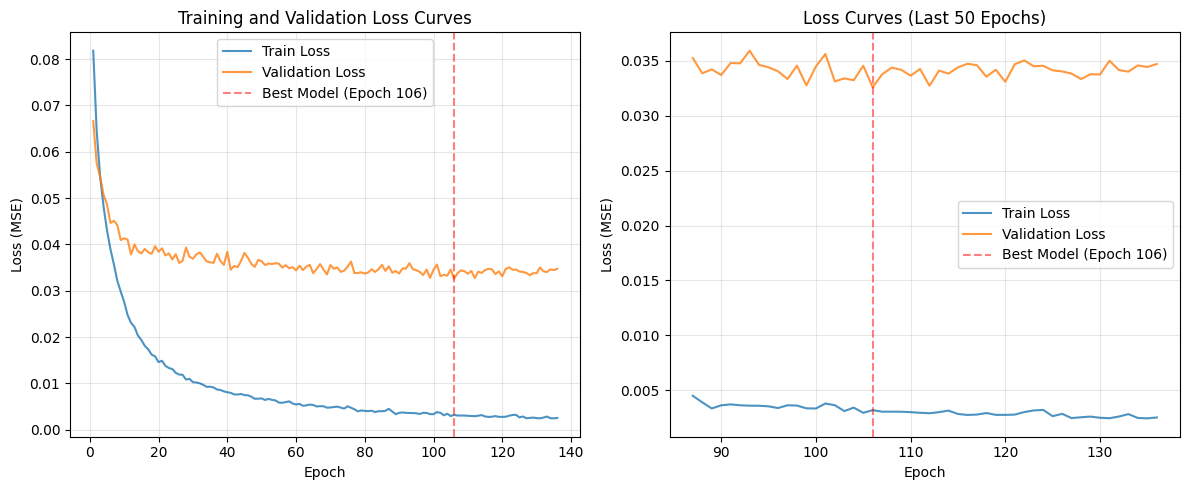

Final Training Loss: 0.002523
Final Validation Loss: 0.034720
Best Validation Loss: 0.032589 at Epoch 106


In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs_list = range(1, len(train_losses) + 1)
plt.plot(epochs_list, train_losses, label='Train Loss', alpha=0.8)
plt.plot(epochs_list, val_losses, label='Validation Loss', alpha=0.8)
if 'best_epoch' in locals():
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if len(train_losses) > 20:
    start_idx = max(0, len(train_losses) - 50)
    plt.plot(epochs_list[start_idx:], train_losses[start_idx:], label='Train Loss', alpha=0.8)
    plt.plot(epochs_list[start_idx:], val_losses[start_idx:], label='Validation Loss', alpha=0.8)
    if 'best_epoch' in locals() and best_epoch > start_idx:
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Curves (Last 50 Epochs)')
else:
    plt.plot(epochs_list, train_losses, label='Train Loss', alpha=0.8)
    plt.plot(epochs_list, val_losses, label='Validation Loss', alpha=0.8)
    if 'best_epoch' in locals():
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
if 'best_val_loss' in locals():
    print(f"Best Validation Loss: {best_val_loss:.6f} at Epoch {best_epoch}")


Device: cpu

=== Test Set Evaluation ===
Samples: 3091
R²   : 0.5673
MAE  : 0.1386
RMSE : 0.1984


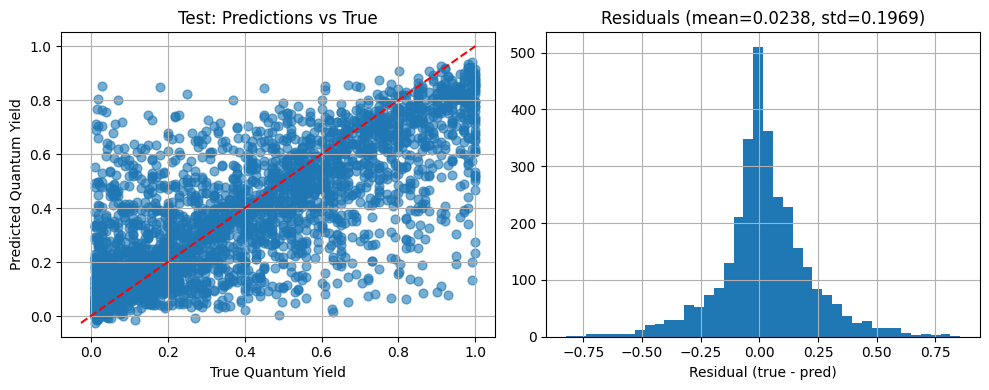

In [18]:
import os
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


if 'transformer_model' not in locals():
    input_dim = chrom_emb_scaled.shape[1]
    transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

    ckpt_path = "models/transformer_best.pth"
    if os.path.exists(ckpt_path):
        transformer_model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint: {ckpt_path}")
    else:
        print("Warning: No trained model found. Please run Cell 13 first to train the model.")

transformer_model.eval()
y_true_list, y_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch) 
        y_true_list.append(yb.cpu())
        y_pred_list.append(pred.cpu())

y_true = torch.cat(y_true_list).squeeze().numpy()
y_pred = torch.cat(y_pred_list).squeeze().numpy()

r2  = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse= np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Test Set Evaluation ===")
print(f"Samples: {len(y_true)}")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.6, s=40)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Test: Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

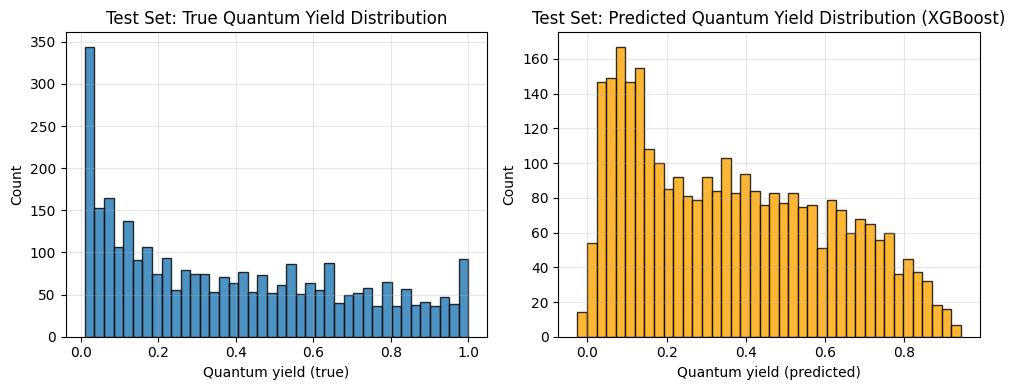

In [19]:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_true, bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield (true)")
plt.ylabel("Count")
plt.title("Test Set: True Quantum Yield Distribution")
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.hist(y_pred, bins=40, alpha=0.8, edgecolor="black", color="orange")
plt.xlabel("Quantum yield (predicted)")
plt.ylabel("Count")
plt.title("Test Set: Predicted Quantum Yield Distribution (XGBoost)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== Improved Transformer Test Set Evaluation ===
Samples: 3091
R²   : 0.5691
MAE  : 0.1350
RMSE : 0.1979


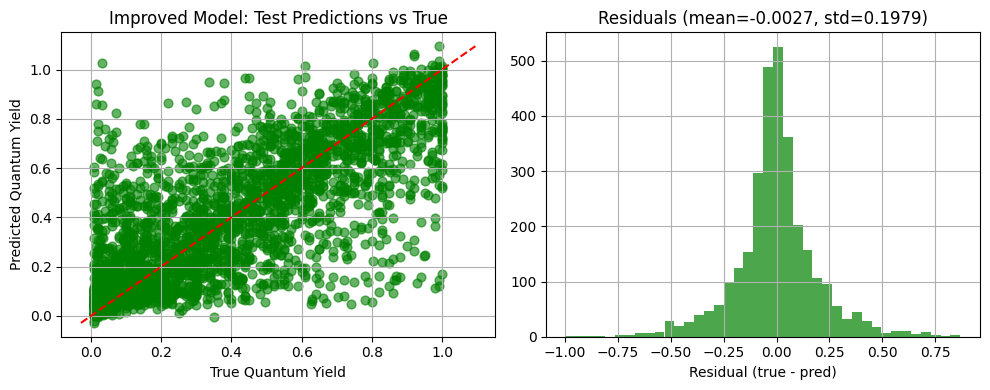

In [20]:

print("\n" + "="*50)
print("=== Improved Transformer Test Set Evaluation ===")
print("="*50)


if 'transformer_improved' not in locals():
    input_dim = chrom_emb_scaled.shape[1]
    transformer_improved = TransformerRegressorImproved(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2, dropout=0.3).to(device)
    ckpt_path = "models/transformer_improved_best.pth"
    if os.path.exists(ckpt_path):
        transformer_improved.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint: {ckpt_path}")
    else:
        print("Warning: No trained improved model found. Please run Cell 14 first.")

transformer_improved.eval()
y_true_improved_list, y_pred_improved_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_improved(chrom_batch, solv_batch)
        y_true_improved_list.append(yb.cpu())
        y_pred_improved_list.append(pred.cpu())

y_true_improved = torch.cat(y_true_improved_list).squeeze().numpy()
y_pred_improved = torch.cat(y_pred_improved_list).squeeze().numpy()

r2_improved  = r2_score(y_true_improved, y_pred_improved)
mae_improved = mean_absolute_error(y_true_improved, y_pred_improved)
rmse_improved = np.sqrt(mean_squared_error(y_true_improved, y_pred_improved))

print(f"Samples: {len(y_true_improved)}")
print(f"R²   : {r2_improved:.4f}")
print(f"MAE  : {mae_improved:.4f}")
print(f"RMSE : {rmse_improved:.4f}")

# Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_true_improved, y_pred_improved, alpha=0.6, s=40, color='green')
mn, mx = min(y_true_improved.min(), y_pred_improved.min()), max(y_true_improved.max(), y_pred_improved.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Improved Model: Test Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals_improved = y_true_improved - y_pred_improved
plt.hist(residuals_improved, bins=40, color='green', alpha=0.7)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals_improved.mean():.4f}, std={residuals_improved.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:

print("\n" + "="*50)
print("=== Improved Transformer Validation Results ===")
print("="*50)

transformer_improved.eval()
y_val_true_improved_list, y_val_pred_improved_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in val_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_improved(chrom_batch, solv_batch)
        y_val_true_improved_list.append(yb.cpu())
        y_val_pred_improved_list.append(pred.cpu())

y_val_true_improved = torch.cat(y_val_true_improved_list).squeeze().numpy()
y_val_pred_improved = torch.cat(y_val_pred_improved_list).squeeze().numpy()

r2_val_improved  = r2_score(y_val_true_improved, y_val_pred_improved)
mae_val_improved = mean_absolute_error(y_val_true_improved, y_val_pred_improved)
rmse_val_improved = np.sqrt(mean_squared_error(y_val_true_improved, y_val_pred_improved))

print(f"Samples: {len(y_val_true_improved)}")
print(f"R²   : {r2_val_improved:.4f}")
print(f"MAE  : {mae_val_improved:.4f}")
print(f"RMSE : {rmse_val_improved:.4f}")


print("\n" + "="*50)
print("=== Improved Transformer Train Set Evaluation ===")
print("="*50)

transformer_improved.eval()
y_train_true_improved_list, y_train_pred_improved_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_improved(chrom_batch, solv_batch)
        y_train_true_improved_list.append(yb.cpu())
        y_train_pred_improved_list.append(pred.cpu())

y_train_true_improved = torch.cat(y_train_true_improved_list).squeeze().numpy()
y_train_pred_improved = torch.cat(y_train_pred_improved_list).squeeze().numpy()

r2_train_improved  = r2_score(y_train_true_improved, y_train_pred_improved)
mae_train_improved = mean_absolute_error(y_train_true_improved, y_train_pred_improved)
rmse_train_improved = np.sqrt(mean_squared_error(y_train_true_improved, y_train_pred_improved))

print(f"Samples: {len(y_train_true_improved)}")
print(f"R²   : {r2_train_improved:.4f}")
print(f"MAE  : {mae_train_improved:.4f}")
print(f"RMSE : {rmse_train_improved:.4f}")



=== Improved Transformer Validation Results ===
Samples: 1546
R²   : 0.6215
MAE  : 0.1260
RMSE : 0.1847

=== Improved Transformer Train Set Evaluation ===
Samples: 10816
R²   : 0.9717
MAE  : 0.0380
RMSE : 0.0510



IMPROVED TRANSFORMER MODEL RESULTS

=== Performance Metrics ===
       Set  Samples       R²      MAE     RMSE
     Train    10816 0.971706 0.037957 0.050974
Validation     1546 0.621471 0.125966 0.184697
      Test     3091 0.569123 0.135018 0.197931

=== Overfitting Analysis ===
  Train-Val R² gap: 0.3502
  Train-Val RMSE gap: 0.1337
  Train-Test R² gap: 0.4026
  Train-Test RMSE gap: 0.1470


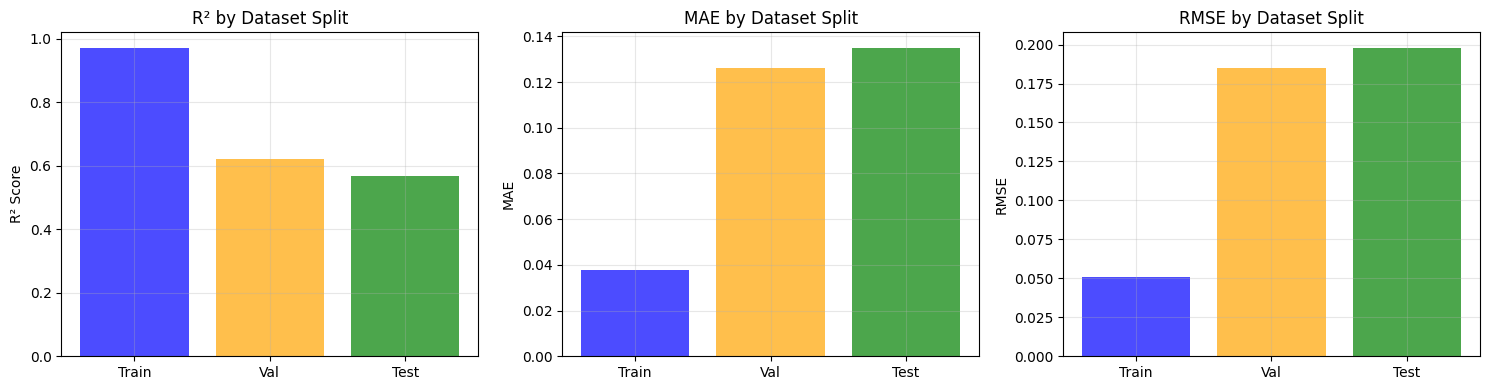

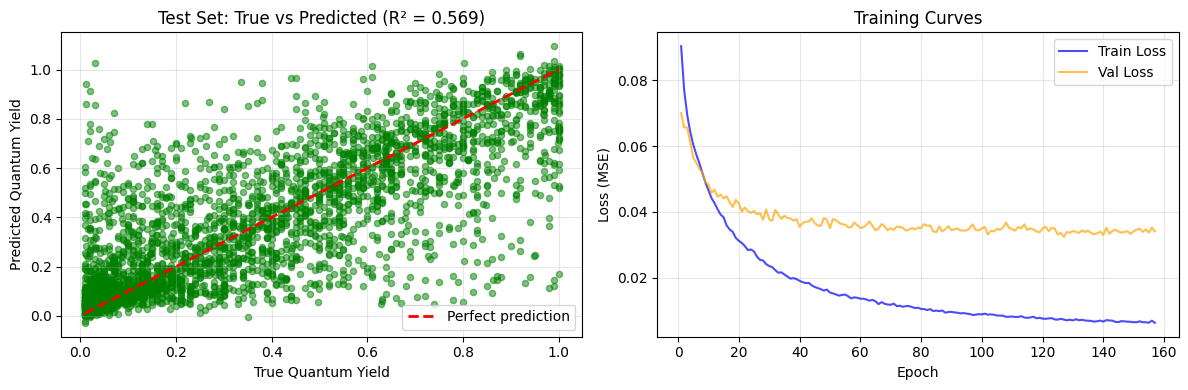


Comparison Complete!


In [22]:
# =============================================================================
# IMPROVED MODEL SUMMARY
# =============================================================================

print("\n" + "="*70)
print("IMPROVED TRANSFORMER MODEL RESULTS")
print("="*70)

comparison_df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train_true_improved), len(y_val_true_improved), len(y_true_improved)],
    "R²": [r2_train_improved, r2_val_improved, r2_improved],
    "MAE": [mae_train_improved, mae_val_improved, mae_improved],
    "RMSE": [rmse_train_improved, rmse_val_improved, rmse_improved]
})

print("\n=== Performance Metrics ===")
print(comparison_df.to_string(index=False))

print("\n=== Overfitting Analysis ===")
print(f"  Train-Val R² gap: {r2_train_improved - r2_val_improved:.4f}")
print(f"  Train-Val RMSE gap: {rmse_val_improved - rmse_train_improved:.4f}")
print(f"  Train-Test R² gap: {r2_train_improved - r2_improved:.4f}")
print(f"  Train-Test RMSE gap: {rmse_improved - rmse_train_improved:.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R² bar chart
axes[0].bar(['Train', 'Val', 'Test'], [r2_train_improved, r2_val_improved, r2_improved], 
            alpha=0.7, color=['blue', 'orange', 'green'])
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² by Dataset Split')
axes[0].grid(True, alpha=0.3)

# MAE bar chart
axes[1].bar(['Train', 'Val', 'Test'], [mae_train_improved, mae_val_improved, mae_improved], 
            alpha=0.7, color=['blue', 'orange', 'green'])
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE by Dataset Split')
axes[1].grid(True, alpha=0.3)

# RMSE bar chart
axes[2].bar(['Train', 'Val', 'Test'], [rmse_train_improved, rmse_val_improved, rmse_improved], 
            alpha=0.7, color=['blue', 'orange', 'green'])
axes[2].set_ylabel('RMSE')
axes[2].set_title('RMSE by Dataset Split')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Additional visualizations
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

# True vs Predicted scatter plot
axes2[0].scatter(y_true_improved, y_pred_improved, alpha=0.5, s=20, color='green')
mn, mx = y_true_improved.min(), y_true_improved.max()
axes2[0].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect prediction')
axes2[0].set_xlabel('True Quantum Yield')
axes2[0].set_ylabel('Predicted Quantum Yield')
axes2[0].set_title(f'Test Set: True vs Predicted (R² = {r2_improved:.3f})')
axes2[0].legend()
axes2[0].grid(True, alpha=0.3)

# Training curves if available
if 'train_losses_improved' in dir():
    epochs_imp = range(1, len(train_losses_improved) + 1)
    axes2[1].plot(epochs_imp, train_losses_improved, label='Train Loss', color='blue', alpha=0.7)
    axes2[1].plot(epochs_imp, val_losses_improved, label='Val Loss', color='orange', alpha=0.7)
    axes2[1].set_xlabel('Epoch')
    axes2[1].set_ylabel('Loss (MSE)')
    axes2[1].set_title('Training Curves')
    axes2[1].legend()
    axes2[1].grid(True, alpha=0.3)
else:
    axes2[1].text(0.5, 0.5, 'Run training cells to see loss curves', 
                  ha='center', va='center', transform=axes2[1].transAxes)
    axes2[1].set_title('Training Curves (not available)')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Comparison Complete!")
print("="*70)



=== Transformer/CrossAttention Validation Results ===
Samples: 1546
R²   : 0.6182
MAE  : 0.1296
RMSE : 0.1855


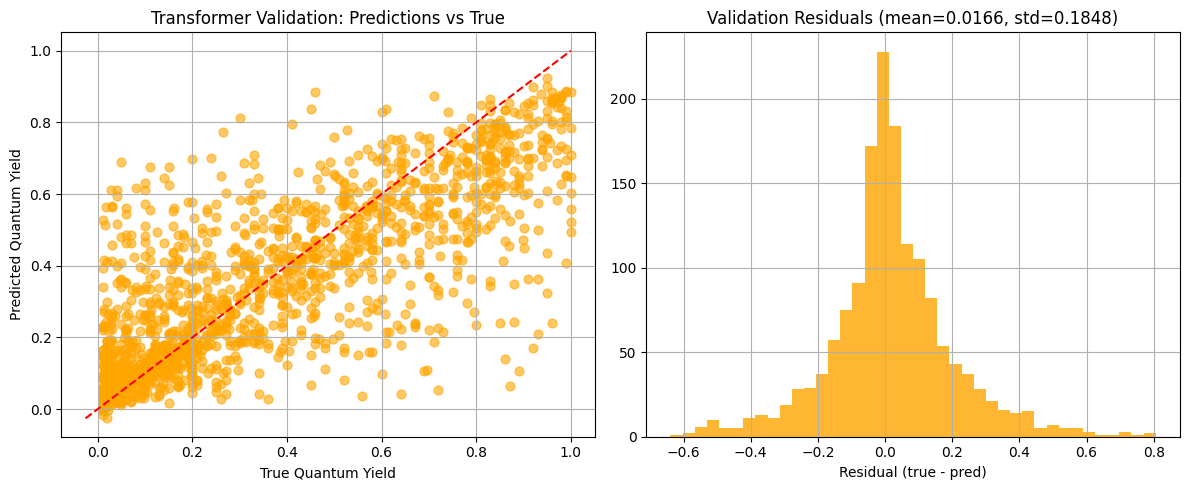

In [23]:
print("\n" + "="*50)
print("=== Transformer/CrossAttention Validation Results ===")
print("="*50)

transformer_model.eval()
y_val_true_list, y_val_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in val_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_val_true_list.append(yb.cpu())
        y_val_pred_list.append(pred.cpu())

y_val_true = torch.cat(y_val_true_list).squeeze().numpy()
y_val_pred = torch.cat(y_val_pred_list).squeeze().numpy()

r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='orange')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Transformer Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='orange')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
print("\n" + "="*50)
print("=== Train Set Evaluation ===")
print("="*50)

transformer_model.eval()
y_train_true_list, y_train_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_train_true_list.append(yb.cpu())
        y_train_pred_list.append(pred.cpu())

y_train_true = torch.cat(y_train_true_list).squeeze().numpy()
y_train_pred = torch.cat(y_train_pred_list).squeeze().numpy()

r2_train  = r2_score(y_train_true, y_train_pred)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

print(f"Samples: {len(y_train_true)}")
print(f"R²   : {r2_train:.4f}")
print(f"MAE  : {mae_train:.4f}")
print(f"RMSE : {rmse_train:.4f}")


comparison_df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train_true), len(y_val_true), len(y_true)],
    "R²": [r2_train, r2_val, r2],
    "MAE": [mae_train, mae_val, mae],
    "RMSE": [rmse_train, rmse_val, rmse]
})

print("\n" + "="*50)
print("=== Model Performance Comparison ===")
print("="*50)
print(comparison_df.to_string(index=False))



=== Train Set Evaluation ===
Samples: 10816
R²   : 0.9746
MAE  : 0.0351
RMSE : 0.0483

=== Model Performance Comparison ===
       Set  Samples       R²      MAE     RMSE
     Train    10816 0.974572 0.035102 0.048323
Validation     1546 0.618155 0.129589 0.185504
      Test     3091 0.567287 0.138596 0.198352
